In [5]:
import pandas as pd

#read file and visualise it
data = pd.read_csv('dataset.csv', nrows=500000)

In [6]:
print(data)

        app_id        app_name  \
0           10  Counter-Strike   
1           10  Counter-Strike   
2           10  Counter-Strike   
3           10  Counter-Strike   
4           10  Counter-Strike   
...        ...             ...   
499995  202130          Impire   
499996  202130          Impire   
499997  202130          Impire   
499998  202130          Impire   
499999  202130          Impire   

                                              review_text  review_score  \
0                                         Ruined my life.             1   
1       This will be more of a ''my experience with th...             1   
2                           This game saved my virginity.             1   
3       • Do you like original games? • Do you like ga...             1   
4                Easy to learn, hard to master.                       1   
...                                                   ...           ...   
499995  While the humor in the game often falls flat, ...         

In [7]:
#Clean the data:
import re
#Remove duplicates, null values, and irrelevant information.
#Handle noisy data (e.g., special characters, HTML tags).
data.drop_duplicates()
#print(data['review_text'])

for review in data['review_text']:
    review = re.sub('[^A-Za-z0-9]+',' ', str(review) ).lower()



In [8]:
data['review_text'].dropna(inplace=True)

#Text preprocessing:
import nltk
from nltk.tokenize import word_tokenize
#nltk.download('punkt')
#Tokenization, lowercasing, removing stopwords, stemming, and lemmatization.
text = data['review_text'].str.lower().astype('str')

text = text.apply(word_tokenize)
text.head()

0                                [ruined, my, life, .]
1    [this, will, be, more, of, a, ``, my, experien...
2                [this, game, saved, my, virginity, .]
3    [•, do, you, like, original, games, ?, •, do, ...
4            [easy, to, learn, ,, hard, to, master, .]
Name: review_text, dtype: object

In [9]:
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
filtered_sentences = []
for texts in text:
    filtered_sentence = []
    for word in texts:
        if word not in stop_words:
            filtered_sentence.append(word.replace('$',''))
    filtered_sentences.append(filtered_sentence)


In [10]:
#stem words
import string
#print(filtered_sentences[0])
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
stemmed_sentences = []

for stentences in filtered_sentences:
    stemmed_sentence = " "
    for word in stentences:
        stemmed_sentence += " " + stemmer.stem(word)
        stemmed_sentence = stemmed_sentence.translate(str.maketrans('', '', string.punctuation))
    stemmed_sentences.append(stemmed_sentence)

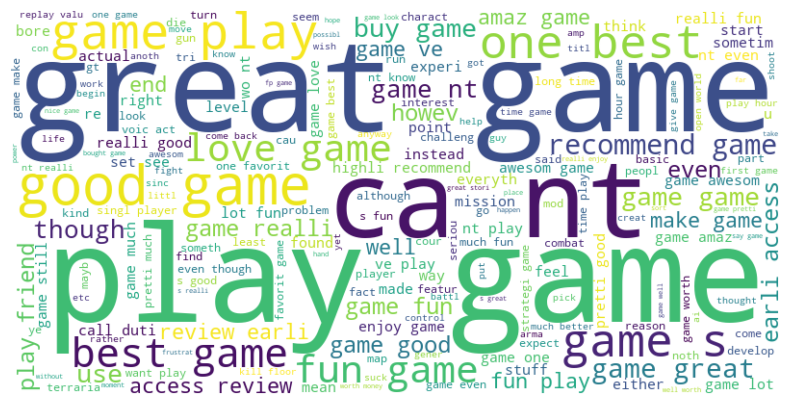

In [11]:
#print(stemmed_sentences[0])
#We already have the labels -1 = negative 1 = positive

#Now to do exploratory data analysis 
data["processed_reviews"] = stemmed_sentences

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate("+".join(data['processed_reviews'].astype('str')))

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.show()

In [12]:
dfe = data['processed_reviews'].explode().to_frame().reset_index(drop=True)
counts = []
for review in dfe['processed_reviews']:
    string = review.split()
    for word in string:
        counts.append(word)
print(len(counts))


13666230


In [13]:
import seaborn as sns
from collections import Counter
counts = Counter(counts)
counts.most_common(10)
#honestly not as good as the word cloud IMO

[('game', 735527),
 ('play', 222974),
 ('s', 187404),
 ('nt', 140295),
 ('like', 136713),
 ('get', 129303),
 ('fun', 114572),
 ('good', 107646),
 ('one', 102560),
 ('great', 97702)]

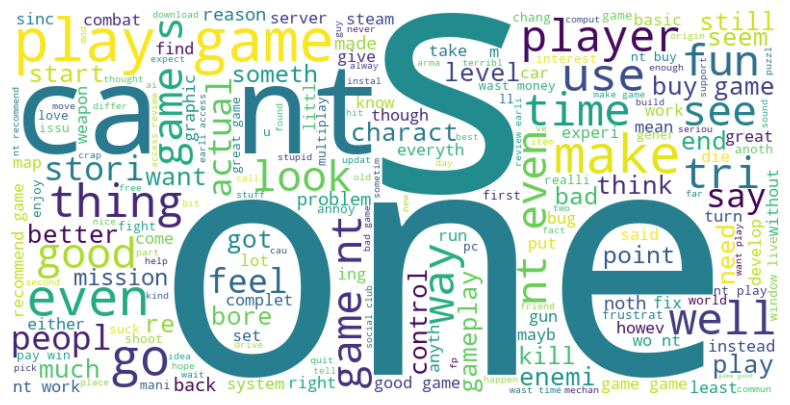

In [14]:
#all negative review word cloud
negative_data = data[data['review_score'] == -1]
# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate("+".join(negative_data['processed_reviews'].astype('str')))

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.show()

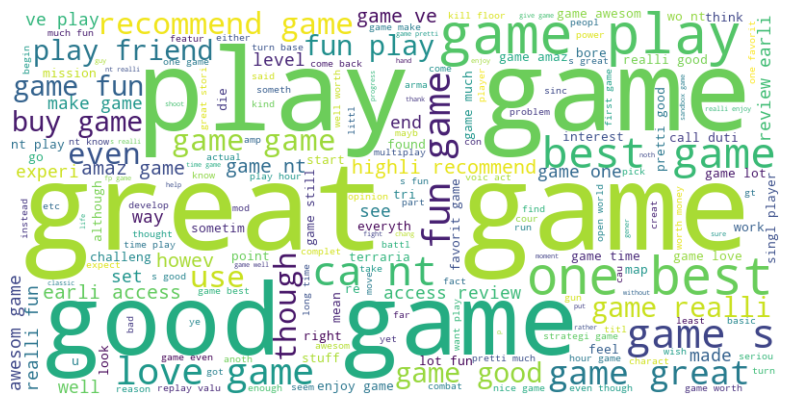

In [15]:
positive_data = data[data['review_score'] == 1]
# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate("+".join(positive_data['processed_reviews'].astype('str')))

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.show()

In [16]:
new_processed_review = data['processed_reviews'].str.split()
data['processed_reviews'] = new_processed_review


In [17]:
import gensim

from gensim.models import Word2Vec, KeyedVectors



model = gensim.models.Word2Vec(
        data['processed_reviews'],
        window=10,
        min_count=2,
        workers=10)

In [18]:
wl = 'game'

model.wv.most_similar(wl)

[('howev', 0.6013117432594299),
 ('fact', 0.5557219982147217),
 ('play', 0.5418004393577576),
 ('although', 0.5377764701843262),
 ('experi', 0.531071662902832),
 ('realli', 0.5194124579429626),
 ('still', 0.5106555819511414),
 ('gameplay', 0.5101234316825867),
 ('one', 0.5089312791824341),
 ('unfortun', 0.5012416839599609)]

In [19]:
pos_samples = data[data['review_score'] == 1]
neg_samples = data[data['review_score'] == -1]
balanced_sample = pd.concat([pos_samples,neg_samples])

In [20]:
#training_set = 210000
#test_set = 90000

import numpy as np

def get_sentence_vector(sentence, model):
    #words = preprocess_text(sentence)
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # Return a zero vector if no word vectors are found

sentence_vectors = [get_sentence_vector(text, model) for text in data['processed_reviews']]

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

labels = data['review_score'].tolist()
X_train, X_test, y_train, y_test = train_test_split(sentence_vectors, labels, test_size=0.2, random_state=42)
# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Accuracy: {accuracy:.2f}')

Logistic Regression Accuracy: 0.90


In [22]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Naive Bayes Accuracy: {accuracy:.2f}')

Naive Bayes Accuracy: 0.79


In [23]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,

                    hidden_layer_sizes=(5, 2), random_state=1)


clf.fit(X_train, y_train)
accuracy = accuracy_score(y_test, y_pred)
print(f'MLP Accuracy: {accuracy:.2f}')

MLP Accuracy: 0.79


C:\Users\Bobby\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [24]:
import pickle

filename = 'nbmodel.sav'
pickle.dump(nb_model, open(filename,'wb'))

In [25]:
filename = 'clfmodel.sav'
pickle.dump(clf, open(filename,'wb'))

In [26]:
print(sentence_vectors[0:3])

[array([-6.63588464e-01,  9.70220804e-01,  4.21149045e-01,  1.44920826e+00,
       -1.51078713e+00, -1.67150652e+00, -2.43480921e+00,  1.10347021e+00,
        1.04920912e+00,  7.49826550e-01,  8.19357753e-01, -1.62195861e-01,
        1.33023143e+00,  2.70077169e-01, -1.71466246e-02, -1.53202307e+00,
       -8.11411023e-01, -4.88566160e-02,  3.58049989e+00,  1.04664516e+00,
        4.25047040e-01,  4.02836353e-01, -1.25686216e+00, -4.63711381e-01,
        8.17660511e-01,  1.59759843e+00, -3.01222116e-01,  1.00940025e+00,
        4.24282265e+00, -1.13662195e+00, -5.11588931e-01, -2.06897068e+00,
        1.36533523e+00, -8.77731144e-01,  1.24459422e+00, -8.14700603e-01,
       -2.45464236e-01,  5.51458478e-01, -1.30837405e+00, -6.90060928e-02,
       -1.47764945e+00,  1.12637353e+00, -1.93641707e-02, -1.07049799e+00,
        2.96362966e-01,  2.33051443e+00,  3.10473800e-01, -2.51041204e-01,
       -1.32067621e+00, -2.53520823e+00,  6.32126451e-01,  4.08262074e-01,
        1.48365426e+00, 

In [29]:
filename = 'lrmodel.sav'
load_model = pickle.load(open(filename,'rb'))
load_model.predict([X_test[3432]])

array([1])

In [28]:
filename = 'w2v.sav'
pickle.dump(model, open(filename,'wb'))